**WEEK - 4**

**Step 1.Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Step 2.Import + Paths(Reuse - week3)**

In [7]:
import os, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Paths same as Week 3
IMAGE_DIR = "/content/drive/MyDrive/VisionExtract/data/coco2017/original_images"
MASK_DIR  = "/content/drive/MyDrive/VisionExtract/data/coco2017/train_masks"

IMG_H, IMG_W = 256, 256
BATCH_SIZE = 8
EPOCHS = 30   # more than Week 3
SEED = 42


**Step - 3. Load Dataset (reuse - Week 3 loader)**

In [12]:
import os, random
import numpy as np
import cv2
from keras.applications.resnet50 import preprocess_input

IMG_H, IMG_W = 256, 256
SEED = 42

# --------- 1) Pairing images and masks (masks have _mask suffix) ----------
def get_pairs(img_dir, mask_dir):
    img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    mask_set = set(mask_files)
    pairs = []
    for img in img_files:
        stem = os.path.splitext(img)[0]            # e.g. 000000184321
        expected_mask = stem + "_mask.png"         # e.g. 000000184321_mask.png
        if expected_mask in mask_set:
            pairs.append((os.path.join(img_dir, img), os.path.join(mask_dir, expected_mask)))
    return pairs

# --------- 2) Simple loader ----------
def load_pairs_to_numpy(pairs, img_h=IMG_H, img_w=IMG_W):
    X = []
    Y = []
    for img_path, mask_path in pairs:
        # read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_w, img_h))
        img = img.astype(np.float32)
        img = preprocess_input(img)

        # read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.uint8)
        mask = mask[..., np.newaxis]

        X.append(img)
        Y.append(mask.astype(np.float32))

    return np.stack(X, axis=0), np.stack(Y, axis=0)


In [10]:
pairs = get_pairs(IMAGE_DIR, MASK_DIR)
print("Total pairs found:", len(pairs))


Total pairs found: 157


In [11]:
# load_pairs_to_numpy and get_pairs functions already defined in Week 3

pairs = get_pairs(IMAGE_DIR, MASK_DIR)
print("Total pairs found:", len(pairs))

# Split Train / Validation
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=SEED)

X_train, y_train = load_pairs_to_numpy(train_pairs)
X_val, y_val     = load_pairs_to_numpy(val_pairs)

print("Train set:", X_train.shape, y_train.shape)
print("Val set:", X_val.shape, y_val.shape)


Total pairs found: 157
Train set: (125, 256, 256, 3) (125, 256, 256, 1)
Val set: (32, 256, 256, 3) (32, 256, 256, 1)


**Step 4. Data Augmentation(flips)**

In [13]:
def augment_image_and_mask(img, mask):
    if random.random() > 0.5:
        img = cv2.flip(img, 1)   # horizontal flip
        mask = cv2.flip(mask, 1)
    if random.random() > 0.5:
        img = cv2.flip(img, 0)   # vertical flip
        mask = cv2.flip(mask, 0)
    return img, mask

def data_generator(X, Y, batch_size=8):
    while True:
        idxs = np.arange(len(X))
        np.random.shuffle(idxs)
        for i in range(0, len(X), batch_size):
            batch_idxs = idxs[i:i+batch_size]
            batch_imgs, batch_masks = [], []
            for j in batch_idxs:
                img, mask = X[j], Y[j]
                img, mask = augment_image_and_mask(img, mask)
                batch_imgs.append(img)
                batch_masks.append(mask)
            yield np.array(batch_imgs), np.array(batch_masks)

train_gen = data_generator(X_train, y_train, batch_size=BATCH_SIZE)
val_gen   = data_generator(X_val, y_val, batch_size=BATCH_SIZE)


**Step 5.Callbacks**

In [14]:
checkpoint_path = "/content/drive/MyDrive/VisionExtract/best_model_week4.keras"

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True)
]


**Step 6.Train with validation**

In [20]:
from keras.models import load_model
from keras.metrics import MeanIoU
import tensorflow as tf

# ---- Redefine custom loss and metric from Week 3 ----
def dice_coef_tf(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss_tf(y_true, y_pred):
    return 1.0 - dice_coef_tf(y_true, y_pred)

bce = tf.keras.losses.BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss_tf(y_true, y_pred)

class PixelAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='pixel_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
        y_true_f = tf.cast(y_true, tf.float32)
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_bin), tf.float32))
        total = tf.cast(tf.size(y_true_f), tf.float32)
        self.correct.assign_add(correct)
        self.total.assign_add(total)
    def result(self):
        return self.correct / (self.total + 1e-8)
    def reset_states(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

# ---- Load model with custom objects ----
custom_objects = {
    "PixelAccuracy": PixelAccuracy,
    "bce_dice_loss": bce_dice_loss
}

MODEL_PATH = "/content/drive/MyDrive/VisionExtract/unet_resnet50.keras"

model = load_model(MODEL_PATH, custom_objects=custom_objects)
print("✅ Model loaded from:", MODEL_PATH)


✅ Model loaded from: /content/drive/MyDrive/VisionExtract/unet_resnet50.keras


In [22]:
val_loss, val_acc, val_iou = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Pixel Accuracy: {val_acc:.4f}")
print(f"Validation Mean IoU: {val_iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - loss: 0.1459 - mean_io_u: 0.3960 - pixel_accuracy: 0.9743
Validation Loss: 0.1459
Validation Pixel Accuracy: 0.9743
Validation Mean IoU: 0.3960


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a few validation samples
for i in range(3):
    idx = np.random.randint(0, len(X_val))
    image, mask_true = X_val[idx], y_val[idx]

    # Predict
    pred = model.predict(np.expand_dims(image, axis=0))[0]
    pred_bin = (pred > 0.5).astype(np.uint8)

    # Show
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(image)

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(mask_true[:,:,0], cmap="gray")

    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(pred_bin[:,:,0], cmap="gray")
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step


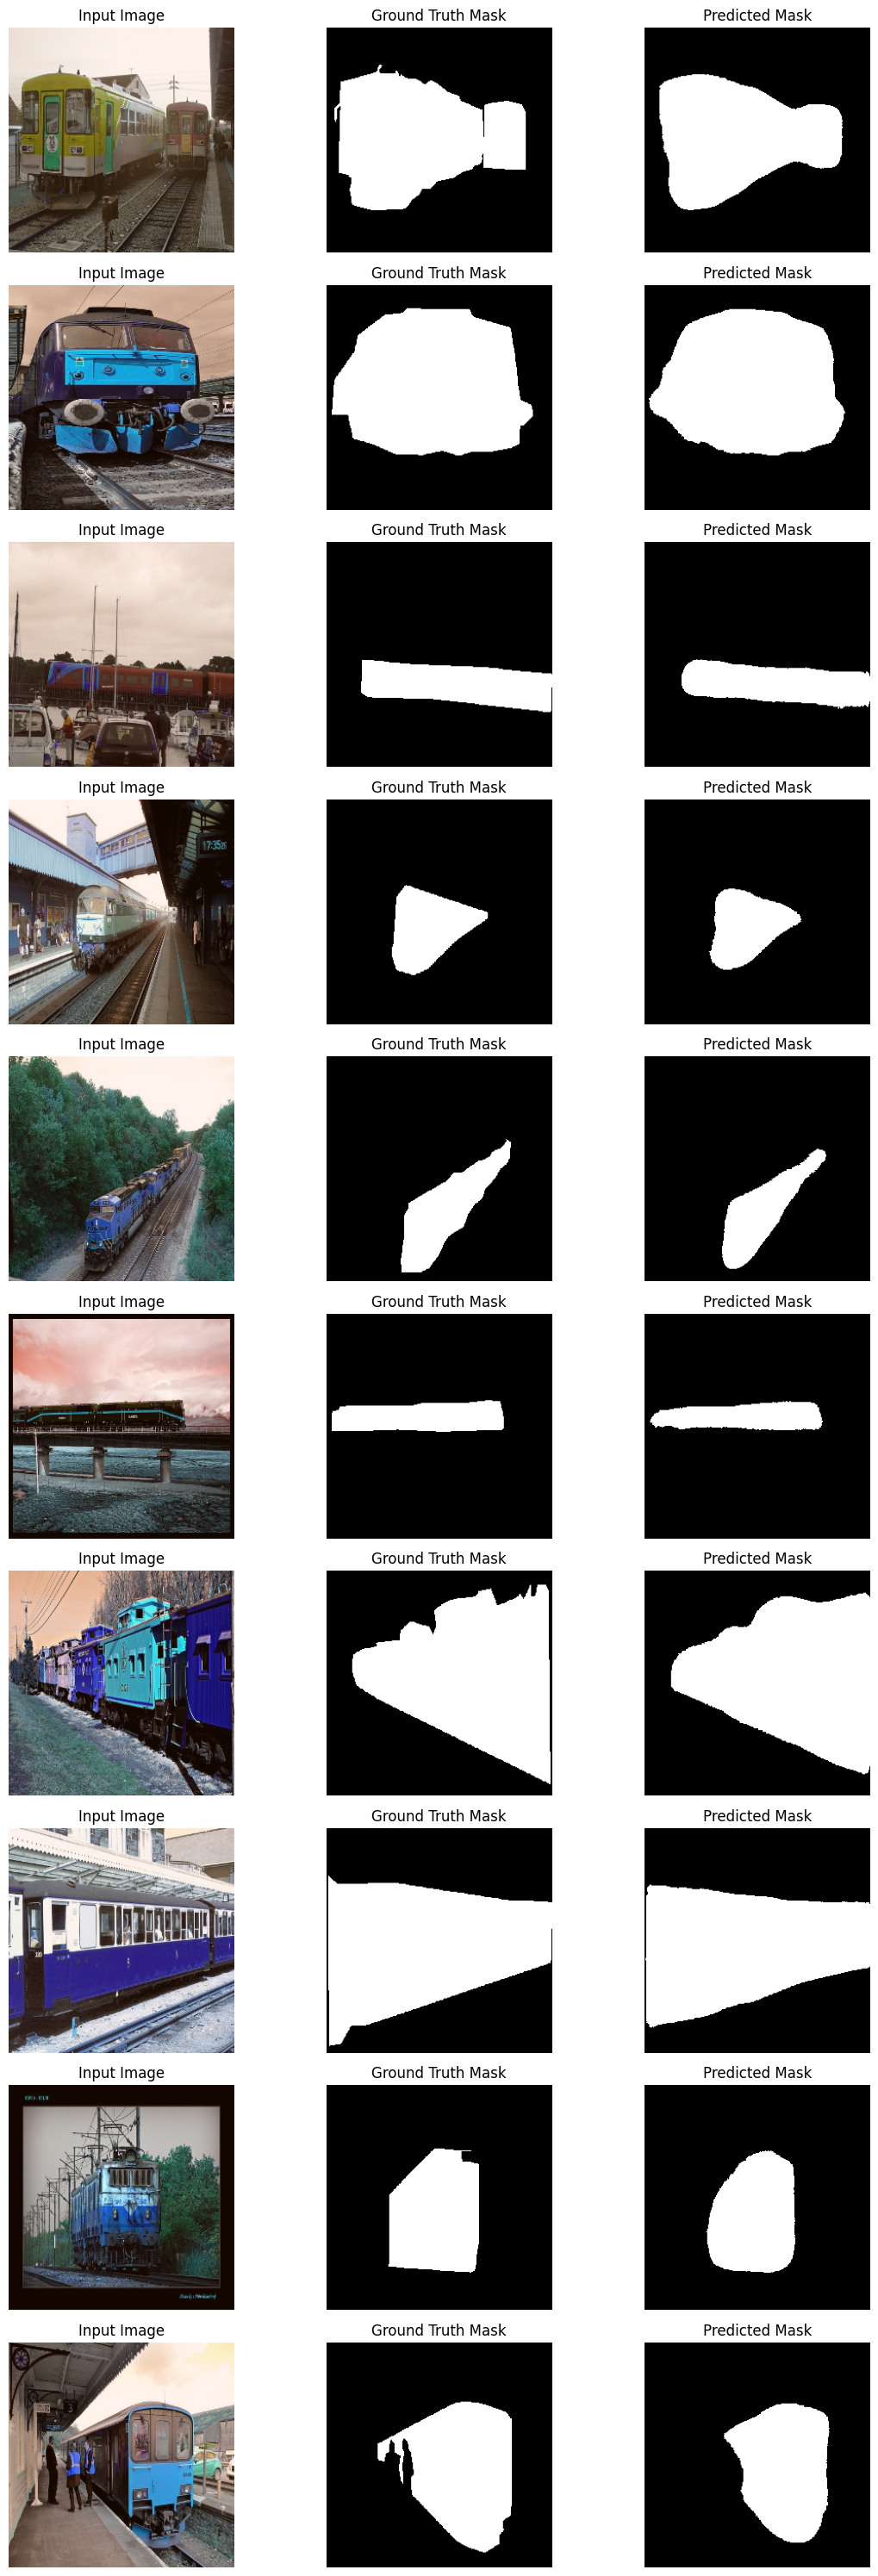

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on validation set
preds_val = model.predict(X_val, batch_size=8)
pred_bins_val = (preds_val > 0.5).astype(np.uint8)

num_show = min(10, X_val.shape[0])  # number of images to show
plt.figure(figsize=(12, num_show * 3))

for i in range(num_show):
    # Convert preprocessed image back to 0..1 range for display
    img_disp = X_val[i].copy()
    img_disp = img_disp - img_disp.min()
    img_disp = img_disp / (img_disp.max() + 1e-8)

    # Plot original image
    plt.subplot(num_show, 3, i*3 + 1)
    plt.imshow(img_disp)
    plt.title("Input Image")
    plt.axis("off")

    # Plot ground truth mask
    plt.subplot(num_show, 3, i*3 + 2)
    plt.imshow(y_val[i].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Plot predicted mask
    plt.subplot(num_show, 3, i*3 + 3)
    plt.imshow(pred_bins_val[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
